In [12]:
pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import os
import torch
import glob
import sklearn
#import sklearn.grid_search
import sklearn.calibration
import sklearn.neighbors
import sklearn.discriminant_analysis
from sklearn.base import BaseEstimator, ClassifierMixin
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from skopt import BayesSearchCV
from skopt.space import Real

from matplotlib import pyplot as plt

    

ModuleNotFoundError: No module named 'skopt'

In [3]:
######################################################################
# This code is to extract useful features from images using VGG 16. The output will be zip files containing 
# pool_size is given when instance_size and instance_stride are none. In this case, 2D ave_pool is applied to the feature extracted from the entire bag image

# On contrary, if instance_size and instance_stride are given, pool_size should be none, Once features are extracted from the instance, global ave_pool is applied

######################################################################

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input
from keras.layers.pooling import GlobalAveragePooling2D, AveragePooling2D
from keras.utils import print_summary

def load_image_list( out_dir ):

    img_files = []
    fd = open( out_dir + 'sample_images.csv' )
    for line in fd:
        files = [ fn.strip() for fn in line.split(',')[1:] if fn.strip() != '' ]
        img_files.extend( files )
    return img_files


src_dir  = './data/HBS_cropped_images/'

if len(src_dir) > 1 and src_dir[-1] != '/':
    src_dir += '/'
    
out_dir = './data/HBS_cropped_images/cnn_feature'
if len(out_dir) > 1 and out_dir[-1] != '/':
    out_dir += '/'
model_name = 'vgg16'
layer = 'block4_pool'
list_layers = True
instance_size = 128
instance_stride = 128
pool_size = None

#load filenames and labels
image_list = load_image_list( out_dir )

# create model
max_dim = None
input_tensor = Input(shape=(max_dim,max_dim,3))
if model_name.lower() == 'vgg16':
    from keras.applications.vgg16 import VGG16
    from keras.applications.vgg16 import preprocess_input
    base_model = VGG16(input_shape=(max_dim,max_dim,3),include_top=False,weights='imagenet')

x = base_model.get_layer(layer).output #extract output of the 4th convolutional layer

# for creating instances(start here)
if pool_size is None and instance_size is None:
    x = GlobalAveragePooling2D(name='avgpool')(x)
elif pool_size is not None:
    p = int(pool_size)
    if p > 0:
        x = AveragePooling2D((p,p),name='avgpool')(x)
elif instance_size is not None:
    size = int(instance_size)
    if instance_stride is not None:
        stride = int(instance_stride)
    else:
        stride = size
    x = GlobalAveragePooling2D(name='avgpool')(x)
model = Model( inputs=base_model.input, outputs=x )

#create batch
for img_fn in image_list:

    img = image.load_img( src_dir+img_fn )
    x = image.img_to_array( img )
    x = np.expand_dims( x, axis=0 )
    x = preprocess_input( x )

    if instance_size is not None:
        feat = []
        bs = 16 #batch size
        x_batch = []
        for r in range(0,x.shape[1],stride):
            for c in range(0,x.shape[2],stride):
                x_inst = x[:,r:min(r+size,x.shape[1]),c:min(c+size,x.shape[2]),:]# x=image, size = instance_size, r = increment by stride size
                
                if len(x_batch) >= bs or ( len(x_batch) > 0 and x_inst.shape != x_batch[0].shape ):
                    # process a batch
                    if len(x_batch) > 1:
                        x_batch = np.concatenate(x_batch,axis=0)
                    else:
                        x_batch = x_batch[0]
                    feat_batch = model.predict(x_batch)
                    feat.append( feat_batch )
                    x_batch = []
                x_batch.append( x_inst )
        if len(x_batch) > 0:
            # process last batch
            if len(x_batch) > 1:
                x_batch = np.concatenate(x_batch,axis=0)
            else:
                x_batch = x_batch[0]
            feat_batch = model.predict(x_batch)
            feat.append( feat_batch )
        if len(feat) > 0:
            feat = np.concatenate( feat, axis=0 )
            feat = [ feat[r,:] for r in range(feat.shape[0]) ]

    #instance size is not known
    else:
        p = model.predict(x)
        if len(p.shape) > 2:
            feat = [ p[:,r,c,:].squeeze() for r in range(p.shape[1]) for c in range(p.shape[2]) ]
        else:
            feat = [ p.squeeze() ]
    if len(feat) > 0:
        print('%d x %d' % (len(feat),feat[0].shape[0]))
    else:
        print('no instances')

    feat_fn = out_dir+img_fn[:img_fn.rfind('.')]+'_'+model_name+'-'+layer
    if pool_size is not None:
        feat_fn += '_p'+str(pool_size)
    if instance_size is not None:
        feat_fn += '_i'+str(instance_size)
        if instance_stride is not None:
            feat_fn += '-'+str(instance_stride)
    feat_fn += '.npy'
    print('Saving '+feat_fn)

    if not os.path.exists( os.path.dirname(feat_fn) ):
        os.makedirs( os.path.dirname(feat_fn) )
    np.save(feat_fn,feat)






58892288/58889256 [==============================] - 7s 0us/step




FileNotFoundError: [Errno 2] No such file or directory: '../HBS_2nd year/data/norm_images/norm_images/S01-324_2/S01-324_2_4_1.png'

#SVM only
class LinearClassifier(BaseEstimator,ClassifierMixin):
    """Linear classifier: logistic regression, SVM."""

    def __init__(self, classifier='svm', kernel='linear', C=1, p=3, gamma=1e0, class_weight='balanced', n_jobs=1, verbose=True):

        self.classifier = classifier
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.p = p
        self.class_weight = class_weight
        self.n_jobs = n_jobs
        self.verbose = verbose
        self._model = None
        self._calib = None

    def fit(self, X, y=None, sample_weight=None, param_search=False, calibrate=False, cv_split=None):
        """Fit the model."""

        if type(X) is list:
            X = np.vstack(X)#convert X into 2D if it is 1D array

        if param_search:
            # search for best hyperparameters
            self.C,self.gamma = self.param_search( X, y, self.C, self.gamma, sample_weight )

        # normalize to zero mean, unit std dev
        self.mu = X.mean(axis=0)
        self.sigma = X.std(axis=0) + 1e-4
        X = ( X - self.mu ) / self.sigma

        # create model
        if self.classifier.lower() == 'logistic':
            self._model = sklearn.linear_model.LogisticRegression( C=self.C, class_weight=self.class_weight, solver='sag' )
        elif self.classifier.lower() == 'svm':
            if self.kernel.lower() == 'linear':
                self._model = sklearn.svm.LinearSVC( C=self.C, class_weight=self.class_weight )
            elif self.kernel.lower() == 'poly':
                self._model = sklearn.svm.SVC( kernel='poly', degree=self.p, C=self.C, class_weight=self.class_weight )
            elif self.kernel.lower() == 'rbf':
                if self.gamma is None:
                    self.gamma = 1.0 / X.shape[1]
                self._model = sklearn.svm.SVC( kernel=self.kernel, C=self.C, gamma=self.gamma, class_weight=self.class_weight, probability=True )
        elif self.classifier.lower() == 'lda':
            self._model = sklearn.discriminant_analysis.LinearDiscriminantAnalysis( solver='lsqr' )

        # calibrate
        if calibrate:
            cl = self._model

            method = 'isotonic'
            if len(y) < 1000:
                method = 'sigmoid'

            if cv_split is not None:
                self._calib = sklearn.calibration.CalibratedClassifierCV( cl, method=method, cv=cv_split )
            else:
                self._calib = sklearn.calibration.CalibratedClassifierCV( cl, method=method, cv=5 )
            y  = y.reshape((len(y),))
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore',category=ConvergenceWarning)
                self._calib.fit( X, y, sample_weight=sample_weight )
        else:
            self._calib = None

        # fit model
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore',category=ConvergenceWarning)
            if sample_weight is not None and self.classifier.lower() != 'lda':
                self._model.fit( X, y.flatten(), sample_weight=sample_weight )
            else:
                self._model.fit( X, y.flatten() )
        
        return self

    def predict(self, X, y=None, cv=None ):
        """Predict."""

        if type(X) is list:
            X = np.vstack(X)
        
        X = ( X - self.mu ) / self.sigma

        if self._calib is not None:
            # use calibration
            if cv is not None:
                p = self._calib.calibrated_classifiers_[cv].predict_proba( X )#calibrated_classifiers_[cv].predict_proba assigend by
            else:
                p = self._calib.predict_proba( X )
        else:
            if self.classifier in ['logistic','svm'] and self.kernel == 'linear':
                d = self._model.decision_function( X )
                p = 1.0 / ( np.exp(-d) + 1 )
                if len(p.shape) == 1:
                    p = p.reshape((len(p),1))
                    p = np.concatenate( (1-p,p), axis=1 )
            else:
                p = self._model.predict_proba( X )

        return p

    def param_search(self, X, y, quick=True, C=None, gamma=None, sample_weight=None):
        """Grid search for best hyperparameters."""

        if type(X) is list:
            X = np.vstack(X)
        
        # normalize to zero mean, unit std dev
        self.mu = X.mean(axis=0)
        self.sigma = X.std(axis=0) + 1e-4
        X = ( X - self.mu ) / self.sigma

        # hyperparameters to search over
        if self.classifier.lower() == 'lda':
            Cvals = [1.0]
            gvals = [1.0]
        elif C is None or not quick:
            Cvals = [float(2**e) for e in range(-15,10)]
            if self.kernel == 'rbf':
                gvals = [float(2**e) for e in range(-20,5)]
            else:
                gvals = [1.0]
        else:
            Cvals = [ float(2**e)*C for e in range(-2,3) ]
            if self.kernel == 'rbf':
                gvals = [ float(2**e)*gamma for e in range(-2,3) ]
            else:
                gvals = [1.0]

        # grid search to find best C
        cv = min(20,min(max((y==0).sum(),(y==-1).sum()),(y==1).sum()))
        metric = 'accuracy'
        if self.classifier.lower() == 'logistic':
            clf = sklearn.model_selection.GridSearchCV( sklearn.linear_model.LogisticRegression( class_weight=self.class_weight, solver='sag' ), [{'C':Cvals}], cv=cv, scoring=metric, n_jobs=self.n_jobs, refit=False )#, fit_params={'sample_weight':sample_weight} )
        elif self.classifier.lower() == 'svm':
            if self.kernel.lower() == 'linear':
                clf = sklearn.model_selection.GridSearchCV( sklearn.svm.LinearSVC( class_weight=self.class_weight ), [{'C':Cvals}], cv=cv, scoring=metric, n_jobs=self.n_jobs, refit=False )#, fit_params={'sample_weight':sample_weight} )
            elif self.kernel == 'poly':
                clf = sklearn.model_selection.GridSearchCV( sklearn.svm.SVC( kernel='poly', degree=self.p, class_weight=self.class_weight ), [{'C':Cvals}], cv=cv, scoring=metric, n_jobs=self.n_jobs, refit=False )#, fit_params={'sample_weight':sample_weight} )
            elif self.kernel == 'rbf':
                clf = sklearn.model_selection.GridSearchCV( sklearn.svm.SVC( kernel='rbf', class_weight=self.class_weight ), [{'C':Cvals,'gamma':gvals}], cv=cv, scoring=metric, n_jobs=self.n_jobs, refit=False )#, fit_params={'sample_weight':sample_weight} )

        import warnings
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore',category=ConvergenceWarning)
            clf.fit( X, y.flatten(), sample_weight=sample_weight )

        C = clf.best_params_['C']
        if self.kernel == 'rbf':
            gamma = clf.best_params_['gamma']

        self.C = C
        self.gamma = gamma

        return C,gamma


In [14]:
#SVM+Bayesian search
class LinearClassifier(BaseEstimator,ClassifierMixin):
    """Linear classifier: logistic regression, SVM."""

    def __init__(self, classifier='svm', kernel='linear', C=1, p=3, gamma=1e0, class_weight='balanced', n_jobs=1, verbose=True):

        self.classifier = classifier
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.p = p
        self.class_weight = class_weight
        self.n_jobs = n_jobs
        self.verbose = verbose
        self._model = None
        self._calib = None

    def fit(self, X, y=None, sample_weight=None, param_search=False, calibrate=False, cv_split=None):
        """Fit the model."""

        if type(X) is list:
            X = np.vstack(X)#convert X into 2D if it is 1D array

        if param_search:
            # search for best hyperparameters
            self.C,self.gamma = self.param_search( X, y, self.C, self.gamma, sample_weight )

        # normalize to zero mean, unit std dev
        self.mu = X.mean(axis=0)
        self.sigma = X.std(axis=0) + 1e-4
        X = ( X - self.mu ) / self.sigma

        # create model
        if self.classifier.lower() == 'logistic':
            self._model = sklearn.linear_model.LogisticRegression( C=self.C, class_weight=self.class_weight, solver='sag' )
        elif self.classifier.lower() == 'svm':
            if self.kernel.lower() == 'linear':
                self._model = sklearn.svm.LinearSVC( C=self.C, class_weight=self.class_weight )
            elif self.kernel.lower() == 'poly':
                self._model = sklearn.svm.SVC( kernel='poly', degree=self.p, C=self.C, class_weight=self.class_weight )
            elif self.kernel.lower() == 'rbf':
                if self.gamma is None:
                    self.gamma = 1.0 / X.shape[1]
                self._model = sklearn.svm.SVC( kernel=self.kernel, C=self.C, gamma=self.gamma, class_weight=self.class_weight, probability=True )
        elif self.classifier.lower() == 'lda':
            self._model = sklearn.discriminant_analysis.LinearDiscriminantAnalysis( solver='lsqr' )

        # calibrate
        if calibrate:
            cl = self._model

            method = 'isotonic'
            if len(y) < 1000:
                method = 'sigmoid'

            if cv_split is not None:
                self._calib = sklearn.calibration.CalibratedClassifierCV( cl, method=method, cv=cv_split )
            else:
                self._calib = sklearn.calibration.CalibratedClassifierCV( cl, method=method, cv=5 )
            y  = y.reshape((len(y),))
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore',category=ConvergenceWarning)
                self._calib.fit( X, y, sample_weight=sample_weight )
        else:
            self._calib = None

        # fit model
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore',category=ConvergenceWarning)
            if sample_weight is not None and self.classifier.lower() != 'lda':
                self._model.fit( X, y.flatten(), sample_weight=sample_weight )
            else:
                self._model.fit( X, y.flatten() )
        
        return self

    def predict(self, X, y=None, cv=None ):
        """Predict."""

        if type(X) is list:
            X = np.vstack(X)
        
        X = ( X - self.mu ) / self.sigma

        if self._calib is not None:
            # use calibration
            if cv is not None:
                p = self._calib.calibrated_classifiers_[cv].predict_proba( X )#calibrated_classifiers_[cv].predict_proba assigend by
            else:
                p = self._calib.predict_proba( X )
        else:
            if self.classifier in ['logistic','svm'] and self.kernel == 'linear':
                d = self._model.decision_function( X )
                p = 1.0 / ( np.exp(-d) + 1 )
                if len(p.shape) == 1:
                    p = p.reshape((len(p),1))
                    p = np.concatenate( (1-p,p), axis=1 )
            else:
                p = self._model.predict_proba( X )

        return p

    def param_search(self, X, y, quick=True, C=None, gamma=None, sample_weight=None):
        """Grid search for best hyperparameters."""

        if type(X) is list:
            X = np.vstack(X)
        
        # normalize to zero mean, unit std dev
        self.mu = X.mean(axis=0)
        self.sigma = X.std(axis=0) + 1e-4
        X = ( X - self.mu ) / self.sigma

        # hyperparameters to search over
        if self.classifier.lower() == 'lda':
            Cvals = [1.0]
            gvals = [1.0]
        elif C is None or not quick:
            Cvals = [float(2**e) for e in range(-15,10)]
            if self.kernel == 'rbf':
                gvals = [float(2**e) for e in range(-20,5)]
            else:
                gvals = [1.0]
        else:
            Cvals = [ float(2**e)*C for e in range(-2,3) ]
            if self.kernel == 'rbf':
                gvals = [ float(2**e)*gamma for e in range(-2,3) ]
            else:
                gvals = [1.0]

        # grid search to find best C
        cv = min(20,min(max((y==0).sum(),(y==-1).sum()),(y==1).sum()))
        metric = 'accuracy'
        print("new function starts")
        if self.classifier.lower() == 'logistic':
            clf = BayesSearchCV( sklearn.linear_model.LogisticRegression( class_weight=self.class_weight, solver='sag' ), [{'C':Real(1e-6, 1e+6, prior='log-uniform')}], cv=cv, scoring=metric, n_jobs=self.n_jobs, refit=False )#, fit_params={'sample_weight':sample_weight} )
        elif self.classifier.lower() == 'svm':
            if self.kernel.lower() == 'linear':
                clf = BayesSearchCV( sklearn.svm.LinearSVC( class_weight=self.class_weight ), [{'C':Real(1e-6, 1e+6, prior='log-uniform')}], cv=cv, scoring=metric, n_jobs=self.n_jobs, refit=False )#, fit_params={'sample_weight':sample_weight} 
            elif self.kernel == 'poly':
                clf = sklearn.model_selection.GridSearchCV( sklearn.svm.SVC( kernel='poly', degree=self.p, class_weight=self.class_weight ), [{'C':Cvals}], cv=cv, scoring=metric, n_jobs=self.n_jobs, refit=False )#, fit_params={'sample_weight':sample_weight} )
            elif self.kernel == 'rbf':
                clf = sklearn.model_selection.GridSearchCV( sklearn.svm.SVC( kernel='rbf', class_weight=self.class_weight ), [{'C':Cvals,'gamma':gvals}], cv=cv, scoring=metric, n_jobs=self.n_jobs, refit=False )#, fit_params={'sample_weight':sample_weight} )

        import warnings
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore',category=ConvergenceWarning)
            clf.fit( X, y.flatten() )

        C = clf.best_params_['C']
        if self.kernel == 'rbf':
            gamma = clf.best_params_['gamma']

        self.C = C
        self.gamma = gamma

        return C,gamma


#Load image dataset
FEATURE_PATH = './data/HBS_cropped_images/cnn_feature/norm_images'
category = 'ER'

# read excel sheet
df = pd.read_csv('refined_clinical_label_MIL.csv')

X = []
Y = []
samples = os.listdir(FEATURE_PATH)
for sample in samples:
    #Read features as X data
    fn_path = os.path.join(FEATURE_PATH, sample)
    fn_num = 0
    feats = []
    for fn in os.listdir(fn_path):
        fn_num += 1
        feat = np.load(os.path.join(fn_path, fn)).reshape(-1)
        feats.append( feat )#read features collapsed into 1D
    
    X.append(feats)
    #print(f'length of X is {len(X)}')
    print('%s %d'%(sample, fn_num))
    
    #Read corresponding Y label
    if np.unique(df[category][df['sample'].str.contains(sample)].to_list()) == 'P':
        Y.extend([1])
    elif np.unique(df[category][df['sample'].str.contains(sample)].to_list()) == 'N':
        Y.extend([0])
    else:
        print('Error: unknown label')
        sys.exit(1)
        
Y = np.array(Y)


Integrated code for presentation purpose

In [15]:
#Load image dataset
FEATURE_PATH = '../HBS_2nd year/data/cnn_feature/norm_images'
category = 'RECUR'

# read excel sheet
df = pd.read_csv('recurrence_mapped.csv')
X = []
Y = []

# exclude_list = ['PATIENT_ID', 'ER', 'PR', 'p53', 'HER2', 'PT_SBST_NO', 'EstimateImmuneScore']
# cols = [col for col in df.columns if col not in exclude_list]
# df_sub = df[cols[1:]][df_features]
# print(df_sub)

for sample in df['PATIENT_ID'].tolist():
    if not sample in os.listdir(FEATURE_PATH):
        continue
    
    #Read features as X data
    fn_path = os.path.join(FEATURE_PATH, sample)
    fn_num = 0
    feats = []
    for fn in os.listdir(fn_path):
        fn_num += 1
        feat = np.load(os.path.join(fn_path, fn)).reshape(-1)# read feature maps from histology images
        #feat = np.append(feat, df_sub.iloc[df.index[df['PATIENT_ID'] == sample].tolist()].values) #append clinical data to feature maps
        
        feats.append( feat )#read features collapsed into 1D
    
    X.append(feats)
    
    print('%s %d'%(sample, fn_num))
    Y.extend(df[category].iloc[df.index[df['PATIENT_ID'] == sample].tolist()].to_numpy())
    #Read corresponding Y labelprint(df.index[df['PATIENT_ID'] == sample])
#     if df[category].iloc[df.index[df['PATIENT_ID'] == sample].tolist()[0]] != 'N':
#         Y.extend([1])        
#     else:
#         Y.extend([0])
Y = np.array(Y)


# build train/test sets
idx = np.arange(len(X))
cv_folds = 5
skf = StratifiedKFold( n_splits=cv_folds, shuffle=True )
idx_train_test = list(skf.split(idx, Y))


#linear SVM training
options = {}
options['kernel'] = 'linear'
options['classifier'] = 'svm'
sw = None
print(category)


#prediction and metric calculation
res = {"acc":[],"f_score":[],"confusion":[], 'auc':[], 'roc':[], 'prc':[], 'auprc':[], 'precision':[], 'recall':[]}
pred_level = 'instance'

for train_index, test_index in idx_train_test:
    

    X_train = []
    y_train = []
    for idx in train_index:
        #X_train.append(np.squeeze(X[idx]))
        X_train.append(np.vstack(X[idx]))
        y_train.extend([Y[idx]]*len(X[idx]))
        #[y_train.append(Y[idx]) for _ in range(len(X[idx]))]


    X_test = []
    y_test_inst = []
    y_test = Y[test_index]#y_test takes bag-level labels
    tile_no_test = []
    for idx in  test_index:
        X_test.append(np.vstack(X[idx]))
        y_test_inst.extend([Y[idx]]*len(X[idx]))
        tile_no_test.append(len(X[idx]))

    X_train = np.vstack(X_train)
    X_test = np.vstack(X_test)

    y_train = np.array(y_train)
    y_test_inst = np.array(y_test_inst)
    

    #calculate sample weight
    sw = compute_sample_weight(class_weight='balanced', y=y_train)
    model = LinearClassifier( n_jobs=7, **options )
    model.fit( X_train, y_train, calibrate=True, param_search=True, sample_weight=sw )

    if pred_level == 'bag':

        prev_idx = 0
        y_p = []

        flag = -3
        y_p_hist = []
        for i, idx in enumerate(tile_no_test):
            y_p_inst = (model.predict(X_test[prev_idx:prev_idx+idx]))
            y_p.append(np.mean(y_p_inst, axis=0))
            y_p_hist.append(np.array(y_p_inst[:, 1]))
            prev_idx = idx

        y_p = np.squeeze(y_p)

        #Store metrics for each fold
        y_predict = np.argmax(np.array(y_p), axis=1)
        acc = sklearn.metrics.accuracy_score( y_test, y_predict )
        f_score = sklearn.metrics.f1_score( y_test, y_predict )

        confusion = sklearn.metrics.confusion_matrix( y_test, y_predict )

        y_p = y_p[:,1]

        fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_p)
        precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_p )


    elif pred_level == 'instance':   
        y_p = model.predict(X_test)

        #Store metrics for each fold
        y_predict = np.argmax(y_p, axis=1)
        acc = sklearn.metrics.accuracy_score( y_test_inst, y_predict )
        f_score = sklearn.metrics.f1_score( y_test_inst, y_predict )

        confusion = sklearn.metrics.confusion_matrix( y_test_inst, y_predict )

        y_p = y_p[:,1]

        fpr, tpr, _ = sklearn.metrics.roc_curve(y_test_inst, y_p)
        precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test_inst, y_p)


    res['acc'].append(acc)
    res['f_score'].append(f_score)
    res['confusion'].append(confusion)
    res['auc'].append(sklearn.metrics.auc(fpr, tpr))
    res['roc'].append([fpr, tpr])
    res['prc'].append([precision, recall])
    res['auprc'].append(sklearn.metrics.auc(recall, precision))
    print(res['acc'], res['f_score'], res['auc'])
    res['precision'].append(precision)
    res['recall'].append(recall)

    if len(res['acc']) < 5:
        del model

        
#prediction results(takes 2+ days to run 3 fold => makes early stop)
#[0.6388409796481546, 0.6901408450704225, 0.5463273392258458] [0.15677852348993288, 0.36198860693940965, 0.2415286624203822] [0.5013086628783953, 0.6521955693163554, 0.4649371855352963]

S01-324_2 475
S01-810_6 691
S01-1722_3 691
S01-1909_7 471
S01-2468_2 120
S01-2618_3 278
S01-2679_1 362
S01-2941_2 77
S01-2945_8 282
S01-3045_2 783
S01-3187_MG1 154
S02-352_3 270
S02-953_1 1001
S02-1406_2 394
S02-1479_6 226
S02-1645_2 228
S02-2353_1 483
S02-3551_2 484
S02-4156_5 166
S02-4327_3 535
S02-5119_3 542
S02-5289_1 438
S02-5984_5 366
S02-6139_3 169
S02-6361_5 334
S02-6394_2 377
S02-7449_5 36
S02-7785_2 123
S02-8135_3 195
S03-711_4 413
S03-1753_3 1517
S03-4251_2 518
S03-4893_2 296
S03-5719_2 238
S03-5766_2 753
S03-5977_2 307
S03-6127_1 147
S03-6753_1 228
S03-6957_2 108
S03-7078_1 174
S03-8439_2 208
S03-8493_2 438
S03-9557_1 167
S03-9688_2 234
S03-10523_6 343
S03-10877_3 208
S03-11164_4 74
S03-12186_6 288
S04-622_2 396
S04-758_1 225
S04-2321_2 525
S04-2336_2 275
S04-2786_3 62
S04-3689_2 39
S04-4708_2 206
S04-5018_1 289
S04-5423_5 92
S04-7588_2 276
S04-8336_2 524
S04-9981_1 277
S04-11592_3 94
S04-11597_2 353
S04-13541_21 169
S04-14331_5 407
S05-2929_6 155
S05-6843_6 215
S05-7054_2 

/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.4615491586705604, 0.5637990364762561] [0.37467700258397935, 0.32039459575380663] [0.45537275783546916, 0.49959000904279116]
new function starts


/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.4615491586705604, 0.5637990364762561, 0.49304825330061924] [0.37467700258397935, 0.32039459575380663, 0.3530639630237066] [0.45537275783546916, 0.49959000904279116, 0.5230762478478885]
new function starts


/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.4615491586705604, 0.5637990364762561, 0.49304825330061924, 0.566237575362555] [0.37467700258397935, 0.32039459575380663, 0.3530639630237066, 0.4141725352112676] [0.45537275783546916, 0.49959000904279116, 0.5230762478478885, 0.5701687680352503]
new function starts
[0.4615491586705604, 0.5637990364762561, 0.49304825330061924, 0.566237575362555, 0.5630588549312692] [0.37467700258397935, 0.32039459575380663, 0.3530639630237066, 0.4141725352112676, 0.16479591836734692] [0.45537275783546916, 0.49959000904279116, 0.5230762478478885, 0.5701687680352503, 0.4006662966017974]


              acc   f_score                            confusion       auc  \
CV1      0.461549  0.374677         [[2159, 2582], [1290, 1160]]  0.455373   
CV2      0.563799  0.320395          [[3349, 1863], [1306, 747]]  0.499590   
CV3      0.493048  0.353064          [[3036, 3489], [850, 1184]]  0.523076   
CV4      0.566238  0.414173          [[2534, 1566], [1096, 941]]  0.570169   
CV5      0.563059  0.164796          [[3896, 2237], [1037, 323]]  0.400666   
average  0.529539  0.325421  [[2994.8, 2347.4], [1115.8, 871.0]]  0.489775   

                                                       roc  \
CV1      [[0.0, 0.0002109259649862898, 0.00084370385994...   
CV2      [[0.0, 0.0009593246354566385, 0.00115118956254...   
CV3      [[0.0, 0.0001532567049808429, 0.00045977011494...   
CV4      [[0.0, 0.0, 0.00024390243902439024, 0.00024390...   
CV5      [[0.0, 0.00016305233980107615, 0.0014674710582...   
average                                                NaN   

                  

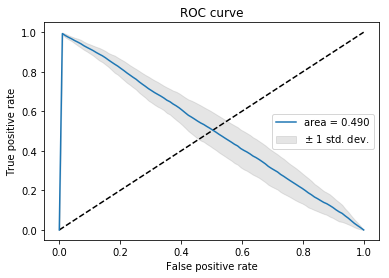

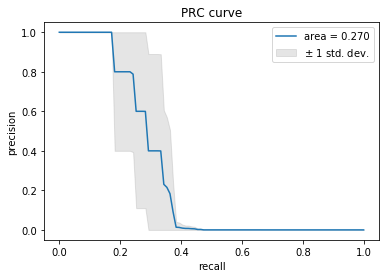

In [17]:
import pickle 

# collate metric results into csv file

df = pd.DataFrame(res, index=[f'CV{i+1}' for i in range(len(res['acc']))])
df.loc['average'] = df.mean(axis=0)
#df['auc'] = [1- x for x in df2['auc']] 
print(df)
#rename = {'0': 'CV1','1': 'CV2','2': 'CV3','3': 'CV4','4': 'CV5','5': 'average'}
#df_metric.rename(index = {str(len(res['acc'])) : 'average'})

metric_col = ['acc', 'f_score', 'auc', 'auprc']
df_metric = df[metric_col]

print(df_metric.columns)

fprs = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(len(df['roc'])-1):
    fpr_,tpr_ = df['roc'][i]
    tprs.append(np.interp(mean_fpr, fpr_, tpr_))

    
mean_tpr = 1-np.mean(tprs, axis=0)
mean_tpr[0] = 0
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)


precisions = []
mean_recall = np.linspace(0, 1, 100)

for i in range(len(df['prc'])-1):
    recall,precision = df['prc'][i]
    precisions.append(np.interp(mean_recall, recall,precision))

mean_precision = np.mean(precisions, axis=0)
std_precision = np.std(precisions, axis=0)
precisions_upper = np.minimum(mean_precision + std_precision, 1)
precisions_lower = np.maximum(mean_precision - std_precision, 0)


#+ 'selected clinical_data'  ''_optimal clinical_' + '_'+
fn = (options['classifier'] +'+' + '_bayesian search_' +  options['kernel'] +'_' + 
      str(category) + '_' + pred_level +'.xlsx')
print(fn)

writer = pd.ExcelWriter(fn, engine = 'xlsxwriter')
df_metric.to_excel(writer, sheet_name = 'metric', float_format = '%.2f')

#append confusion matrix and ROC/PRC curve values
df_c = pd.DataFrame(df['confusion'].sum(), columns = ['N', 'P'], index = ['N', 'P'])#retrieve confusion matrix
df_d = np.transpose(pd.DataFrame([mean_fpr, mean_tpr, mean_recall, mean_precision])) #to plot ROC/PRC curve in excel
df_c.to_excel(writer, sheet_name = 'confusion matrix', float_format = '%.0f')
df_d.to_excel(writer, sheet_name = 'curve', float_format = '%.2f')
writer.save()
writer.close()

    
#print out ROC 
plt.figure(0)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(mean_fpr, mean_tpr, label = 'area = {:.3f}'.format(df_metric['auc']['average']))
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(fn[:-5] + 'roc' +'.jpg')
plt.show()

#print out PRC curves
plt.figure(0)
plt.plot(mean_recall, mean_precision, label = 'area = {:.3f}'.format(df_metric['auprc']['average']))
plt.fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.legend(loc='best')
plt.savefig(fn[:-5] + 'prc' +'.jpg')
plt.show()

model_name = fn[:-4] + 'sav'
pickle.dump(model, open(model_name, 'wb'))

break-down codes

In [21]:
FEATURE_PATH = './data/HBS_cropped_images/cnn_feature/norm_images'
category = 'HER2'

# read excel sheet
df = pd.read_csv('HBS_final_dataset_old.csv')
X = []
Y = []

exclude_list = ['PATIENT_ID', 'ER', 'PR', 'p53', 'HER2', 'PT_SBST_NO', 'EstimateImmuneScore']
cols = [col for col in df.columns if col not in exclude_list]
df_sub = df[cols[1:]][df_features]
print(df_sub)

samples = os.listdir(FEATURE_PATH)
for sample in df['PATIENT_ID'].tolist():
    if not sample in os.listdir(FEATURE_PATH):
        continue
    
    #Read features as X data
    fn_path = os.path.join(FEATURE_PATH, sample)
    fn_num = 0
    feats = []
    for fn in os.listdir(fn_path):
        fn_num += 1
        feat = np.load(os.path.join(fn_path, fn)).reshape(-1)# read feature maps from histology images
        feat = np.append(feat, df_sub.iloc[df.index[df['PATIENT_ID'] == sample].tolist()].values) #append clinical data to feature maps
        
        feats.append( feat )#read features collapsed into 1D
    
    X.append(feats)
    
    print('%s %d'%(sample, fn_num))
    Y.extend(df[category].iloc[df.index[df['PATIENT_ID'] == sample].tolist()].to_numpy())
    #Read corresponding Y labelprint(df.index[df['PATIENT_ID'] == sample])
#     if df[category].iloc[df.index[df['PATIENT_ID'] == sample].tolist()[0]] != 'N':
#         Y.extend([1])        
#     else:
#         Y.extend([0])
Y = np.array(Y)

S06-5210_10 577
S05-8619_3 129
S13-9576_5 91
S01-810_6 691
S03-6753_1 228
S10-19440_5 317
S08-15785_1 96
S02-1406_2 394
S02-1479_6 226
S03-12186_6 288
S12-2933_3 588
S05-9934_1 320
S05-8040_1 749
S06-8181_4 200
S01-2468_2 120
S13-13672_6 113
S03-9688_2 234
S12-22935_7 291
S01-3045_2 783
S05-14364_6 124
S14-28337_2 169
S01-1722_3 691
S01-1909_7 471
S16-19149_2 390
S06-6330_5 59
S03-5977_2 307
S03-7078_1 174
S03-5719_2 238
S03-10523_6 343
S13-13637_13 63
S11-19435_4 294
S04-5018_1 289
S04-758_1 225
S04-7588_2 276
S01-2945_8 282
S03-9557_1 167
S13-27756_4 90
S12-23555_8 361
S02-4327_3 535
S09-28278_4 568
S04-13541_21 169
S04-2321_2 525
S05-14934_1 254
S10-24386_3 226
S04-2786_3 62
S02-4156_5 166
S14-21027_4 265
S03-10877_3 208
S02-953_1 1001
S16-27292_2 66
S02-5119_3 542
S01-3187_MG1 154
S03-8493_2 438
S05-15535_1 355
S16-3751_2 69
S05-7054_2 155
S05-6843_6 215
S11-8680_2 124
S11-29239_2 118
S17-27541_3 164
S02-5984_5 366
S17-1064_MG1 114
S14-14233_2 464
S15-14043_2 161
S02-2353_1 483
S09

In [22]:
print(len(X[0][0]))
print(len(X))
print(len(Y))

8192
85
85


In [23]:
Y = np.array(Y)
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0])

(array([63.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 22.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

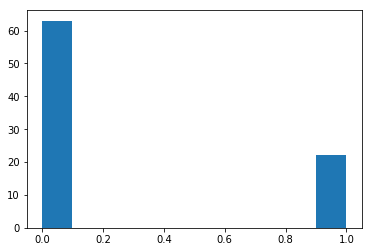

In [24]:
plt.hist(Y)

In [25]:
# build train/test sets. see https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
idx = np.arange(len(X))
cv_folds = 5
skf = StratifiedKFold( n_splits=cv_folds, shuffle=True )
idx_train_test = list(skf.split(idx, Y))

In [ ]:
#linear SVM training
options = {}
options['kernel'] = 'linear'
options['classifier'] = 'svm'
oversample = 0
sw = None
print(category)


#prediction and metric calculation
res = {"acc":[],"f_score":[],"confusion":[], 'auc':[], 'roc':[], 'prc':[], 'auprc':[], 'precision':[], 'recall':[]}
pred_level = 'instance'

for train_index, test_index in idx_train_test:
    

    X_train = []
    y_train = []
    for idx in train_index:
        #X_train.append(np.squeeze(X[idx]))
        X_train.append(np.vstack(X[idx]))
        y_train.extend([Y[idx]]*len(X[idx]))
        #[y_train.append(Y[idx]) for _ in range(len(X[idx]))]


    X_test = []
    y_test_inst = []
    y_test = Y[test_index]#y_test takes bag-level labels
    tile_no_test = []
    for idx in  test_index:
        X_test.append(np.vstack(X[idx]))
        y_test_inst.extend([Y[idx]]*len(X[idx]))
        tile_no_test.append(len(X[idx]))

    X_train = np.vstack(X_train)
    X_test = np.vstack(X_test)

    y_train = np.array(y_train)
    y_test_inst = np.array(y_test_inst)
    

    if oversample:
        
        adasyn = ADASYN(random_state=42, n_jobs=-1)
        X_train_over, y_train_over = adasyn.fit_sample(X_train, y_train)
        print('적용전',X_train.shape, y_train.shape)
        print('적용후',X_train_over.shape, y_train_over.shape)
        model = LinearClassifier( n_jobs=7, **options )
        model.fit( X_train_over, y_train_over, calibrate=True, param_search=True, sample_weight=sw )
    else:
        #calculate sample weight
        sw = compute_sample_weight(class_weight='balanced', y=y_train)
        model = LinearClassifier( n_jobs=7, **options )
        model.fit( X_train, y_train, calibrate=True, param_search=True, sample_weight=sw )

    #y_p = model.predict(X_test)
    #prediction and metric calculation
    # bag-level predict 

    if pred_level == 'bag':

        prev_idx = 0
        y_p = []

        flag = -3
        y_p_hist = []
        for i, idx in enumerate(tile_no_test):
            y_p_inst = (model.predict(X_test[prev_idx:prev_idx+idx]))
            y_p.append(np.mean(y_p_inst, axis=0))
            y_p_hist.append(np.array(y_p_inst[:, 1]))
            prev_idx = idx

        y_p = np.squeeze(y_p)

        #Store metrics for each fold
        y_predict = np.argmax(np.array(y_p), axis=1)
        acc = sklearn.metrics.accuracy_score( y_test, y_predict )
        f_score = sklearn.metrics.f1_score( y_test, y_predict )

        confusion = sklearn.metrics.confusion_matrix( y_test, y_predict )

        y_p = y_p[:,1]

        fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_p)
        precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_p )


    elif pred_level == 'instance':   
        y_p = model.predict(X_test)

        #Store metrics for each fold
        y_predict = np.argmax(y_p, axis=1)
        acc = sklearn.metrics.accuracy_score( y_test_inst, y_predict )
        f_score = sklearn.metrics.f1_score( y_test_inst, y_predict )

        confusion = sklearn.metrics.confusion_matrix( y_test_inst, y_predict )

        y_p = y_p[:,1]

        fpr, tpr, _ = sklearn.metrics.roc_curve(y_test_inst, y_p)
        precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test_inst, y_p)


    res['acc'].append(acc)
    res['f_score'].append(f_score)
    res['confusion'].append(confusion)
    res['auc'].append(sklearn.metrics.auc(fpr, tpr))
    res['roc'].append([fpr, tpr])
    res['prc'].append([precision, recall])
    res['auprc'].append(sklearn.metrics.auc(recall, precision))
    print(res['acc'], res['f_score'], res['auc'])
    res['precision'].append(precision)
    res['recall'].append(recall)

    if len(res['acc']) < 5:
        del model



Angelova_Mean
new function starts
[0.5872063968015993] [0.23659889094269873] [0.5296318051076946]
new function starts


/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.5872063968015993, 0.5858803271631511] [0.23659889094269873, 0.5194805194805194] [0.5296318051076946, 0.6337096217448543]
new function starts


/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.5872063968015993, 0.5858803271631511, 0.7103534008169065] [0.23659889094269873, 0.5194805194805194, 0.5775705775705777] [0.5296318051076946, 0.6337096217448543, 0.7521022676051661]
new function starts


/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.5872063968015993, 0.5858803271631511, 0.7103534008169065, 0.7320125130344108] [0.23659889094269873, 0.5194805194805194, 0.5775705775705777, 0.3967136150234742] [0.5296318051076946, 0.6337096217448543, 0.7521022676051661, 0.6697122186443717]
new function starts


In [ ]:

# collate metric results into csv file

df = pd.DataFrame(res, index=[f'CV{i+1}' for i in range(len(res['acc']))])
df.loc['average'] = df.mean(axis=0)
#df['auc'] = [1- x for x in df2['auc']] 
print(df)
#rename = {'0': 'CV1','1': 'CV2','2': 'CV3','3': 'CV4','4': 'CV5','5': 'average'}
#df_metric.rename(index = {str(len(res['acc'])) : 'average'})

metric_col = ['acc', 'f_score', 'auc', 'auprc']
df_metric = df[metric_col]

print(df_metric.columns)

fprs = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(len(df['roc'])-1):
    fpr_,tpr_ = df['roc'][i]
    tprs.append(np.interp(mean_fpr, fpr_, tpr_))

    
mean_tpr = 1-np.mean(tprs, axis=0)
mean_tpr[0] = 0
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)


precisions = []
mean_recall = np.linspace(0, 1, 100)

for i in range(len(df['prc'])-1):
    recall,precision = df['prc'][i]
    precisions.append(np.interp(mean_recall, recall,precision))

mean_precision = np.mean(precisions, axis=0)
std_precision = np.std(precisions, axis=0)
precisions_upper = np.minimum(mean_precision + std_precision, 1)
precisions_lower = np.maximum(mean_precision - std_precision, 0)


#+ 'selected clinical_data'  ''_optimal clinical_' + '_'+
fn = (options['classifier'] +'+' + '_bayesian search_' +  options['kernel'] +'_' + 
      str(category) + '_' + pred_level +'.xlsx')
print(fn)

writer = pd.ExcelWriter(fn, engine = 'xlsxwriter')
df_metric.to_excel(writer, sheet_name = 'metric', float_format = '%.2f')

#append confusion matrix and ROC/PRC curve values
df_c = pd.DataFrame(df['confusion'].sum(), columns = ['N', 'P'], index = ['N', 'P'])#retrieve confusion matrix
df_d = np.transpose(pd.DataFrame([mean_fpr, mean_tpr, mean_recall, mean_precision])) #to plot ROC/PRC curve in excel
df_c.to_excel(writer, sheet_name = 'confusion matrix', float_format = '%.0f')
df_d.to_excel(writer, sheet_name = 'curve', float_format = '%.2f')
writer.save()
writer.close()

    
#print out ROC 
plt.figure(0)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(mean_fpr, mean_tpr, label = 'area = {:.3f}'.format(df_metric['auc']['average']))
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(fn[:-5] + 'roc' +'.jpg')
plt.show()

#print out PRC curves
plt.figure(0)
plt.plot(mean_recall, mean_precision, label = 'area = {:.3f}'.format(df_metric['auprc']['average']))
plt.fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.legend(loc='best')
plt.savefig(fn[:-5] + 'prc' +'.jpg')
plt.show()

model_name = fn[:-4] + 'sav'
pickle.dump(model, open(model_name, 'wb'))

In [ ]:
#https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
model_name = fn[:-4] + 'sav'
pickle.dump(model, open(model_name, 'wb'))